# Preliminaries

## Library imports

In [1]:
import pandas as pd
import numpy as np
from typing import Callable, List, Optional, Tuple
from pandas import option_context
from pandarallel import pandarallel

# vizualisation
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# NLP
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import words, stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import tensorflow as tf
import tensorflow.keras
import tensorflow_hub as hub
import gensim
from gensim.sklearn_api import D2VTransformer
from transformers import BertTokenizer, BertModel

# general ML
from sklearn.pipeline import Pipeline
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import confusion_matrix
import torch
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

## Downloads

- nltk.download('punkt')
- nltk.download('stopwords')
- nltk.download('words')
- nltk.download('wordnet')
- nltk.download('omw-1.4')

## Data loading

In [2]:
df = pd.read_csv('Data/cleaned_data.csv')

## Settings

In [3]:
# to use all CPUs & display progress bars
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## X, y

In [4]:
X = df['description']
X

0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
                              ...                        
1045    Oren Empower Extra Large Self Adhesive Sticker...
1046    Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047    Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048    Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049    Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...
Name: description, Length: 1050, dtype: object

In [5]:
y = df['lvl_1_category_encoded']
y

0       4
1       0
2       0
3       4
4       4
       ..
1045    0
1046    0
1047    0
1048    0
1049    0
Name: lvl_1_category_encoded, Length: 1050, dtype: int64

# Data overview

In [6]:
display(df.head())
df.info()

,description,image,lvl_1_category,lvl_2_category,lvl_3_category,lvl_1_category_encoded
0,Key Features of Elegance Polyester Multicolor ...,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,Curtains & Accessories,Curtains,4
1,Specifications of Sathiyas Cotton Bath Towel (...,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,Baby Bath & Skin,Baby Bath Towels,0
2,Key Features of Eurospa Cotton Terry Face Towe...,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,Baby Bath & Skin,Baby Bath Towels,0
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,Bed Linen,Bedsheets,4
4,Key Features of Jaipur Print Cotton Floral Kin...,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,Bed Linen,Bedsheets,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   description             1050 non-null   object
 1   image                   1050 non-null   object
 2   lvl_1_category          1050 non-null   object
 3   lvl_2_category          1050 non-null   object
 4   lvl_3_category          1050 non-null   object
 5   lvl_1_category_encoded  1050 non-null   int64 
dtypes: int64(1), object(5)
memory usage: 49.3+ KB


# Defining preprocessing classes

I create classes so that I can put them in a grid search (see the last part : Supervised classification).

## Preprocessor before BoW and Doc2Vec

In [7]:
stop_words = set(stopwords.words('english'))           # from nltk.corpus import stopwords
eng_words = [w.lower() for w in words.words()]         # from nltk.corpus import words


class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, remove_rare_tokens=True, min_token_len=1, only_eng=True, lemm_or_stemm=None, rejoin=True):
        self.remove_rare_tokens = remove_rare_tokens
        self.min_token_len = min_token_len
        self.only_eng = only_eng
        self.lemm_or_stemm = lemm_or_stemm
        self.rejoin = rejoin

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        preprocessed_documents = []
        
        if self.remove_rare_tokens:
            corpus = " ".join(X)
            corpus_lowered = corpus.lower()
            tokens_list = word_tokenize(corpus_lowered)
            tokens_freq = pd.Series(tokens_list).value_counts()
            rare_tokens_list = list(tokens_freq[tokens_freq==1].index)
            
        for document in X:
            # Step 1: Lowercase the document
            document = document.lower()

            # Step 2: Tokenize the document
            tokens = word_tokenize(document)

            # Step 3: Remove general stopwords
            tokens = [token for token in tokens if token not in stop_words]

            # Step 4: Remove rare tokens (those which occur only one time in all corpus)
            if self.remove_rare_tokens:
                tokens = [token for token in tokens if token not in rare_tokens_list]
            
            # Step 5: Remove tokens of length inferior to min_token_length
            tokens = [token for token in tokens if len(token) >= self.min_token_len]

            # Step 6: Keep only alphabetical characters
            tokens = [token for token in tokens if token.isalpha()]
            
            # Step 7: Keep only english words, if requested
            if self.only_eng:
                tokens = [token for token in tokens if token in eng_words]
            
            # Step 8: Stemmatize or lemmatize, if requested
            if self.lemm_or_stemm == "lemm":
                trans = WordNetLemmatizer()
                tokens = [trans.lemmatize(token) for token in tokens]
            elif self.lemm_or_stemm == "stemm":
                trans = PorterStemmer()
                tokens = [trans.stem(token) for token in tokens]

            # Step 9: Join the tokens back into a single string, if requested
            if self.rejoin:
                preprocessed_documents.append(" ".join(tokens))
            else:
                preprocessed_documents.append(tokens)

        return preprocessed_documents

## Custom BERT

In [8]:
class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        bert_tokenizer,
        bert_model,
        embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.bert_model.eval()
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        tokenized_text = self.bert_tokenizer.encode_plus(text,
                                                         add_special_tokens=True,
                                                         max_length=self.bert_tokenizer.model_max_length,
                                                         truncation=True,
                                                        )["input_ids"]

        # Create an attention mask telling BERT to use all words
        attention_mask = [1] * len(tokenized_text)

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.bert_model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

bert_transformer = BertTransformer(bert_tokenizer, bert_model)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Custom USE

In [9]:
class USEWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, model_path):
        self.model_path = model_path
        self.model = None

    def fit(self, X, y=None):
        self.model = hub.load(self.model_path)
        return self

    def transform(self, X):
        embeddings = []
        for sentence in X:
            embedding = self.model([sentence])[0].numpy()
            embeddings.append(embedding)
        return np.array(embeddings)
    
    def fit_transform(self, X, y=None):
        self.model = hub.load(self.model_path)

# Path to the pre-trained Universal Sentence Encoder model
USE_model_path = "https://tfhub.dev/google/universal-sentence-encoder/4"

# Create the USEWrapper instance
USE_wrapper = USEWrapper(USE_model_path)

# T-SNE visualization

In [10]:
tsne = TSNE(n_components=2, init="random")

kmeans = KMeans(n_clusters=7, n_init=10)

y_axis_labels =[]
for i in range(len(df['lvl_1_category'].unique())):
    idx = np.where(df['lvl_1_category_encoded'].unique()==i)[0][0]
    y_axis_labels.append(df['lvl_1_category'].unique()[idx])

def get_TSNE_ARI_confusion_matrix(embedding_model, X, embedding_type):
    embedding_model.fit(X)
    X_ = embedding_model.transform(X)
    X_tsne = tsne.fit_transform(X_)
    clusters = kmeans.fit_predict(X_tsne)
    
    ARI = round(adjusted_rand_score(df['lvl_1_category'], clusters), 2)
    print('Adjusted Rand Index = ', ARI)
    
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16, 7))
    plt.suptitle(f'T-SNE from {embedding_type} embedding', 
                 fontsize=16, 
                 fontweight = 'bold')
    ax1.set_title('colored by true classes', fontsize=14)
    ax1.set_xlabel('component 1', fontsize = 12.5)
    ax1.set_ylabel('component 2', fontsize = 12.5)
    ax2.set_title('colored by K-Means clusters', fontsize=14)
    ax2.set_xlabel('component 1', fontsize = 12.5)
    ax2.set_ylabel('component 2', fontsize = 12.5)
    sns.scatterplot(x=X_tsne[:,0], 
                    y=X_tsne[:,1], 
                    hue=df['lvl_1_category'],
                    #hue_order=y_axis_labels,
                    alpha=0.6, 
                    ax=ax1)
    sns.scatterplot(x=X_tsne[:,0], 
                    y=X_tsne[:,1], 
                    hue=clusters,
                    palette=sns.color_palette('tab10', n_colors=7), 
                    alpha=0.6, 
                    ax=ax2)
    plt.show()  
    
    cm = confusion_matrix(df['lvl_1_category_encoded'], clusters)

    plt.title('Confusion matrix\n', fontsize=15, fontweight = 'bold')
    ax = sns.heatmap(cm, annot=True, fmt='g', yticklabels=y_axis_labels, cmap="Blues")
    ax.set(xlabel='\nK-Means clusters', ylabel='True classes\n');

## On TF embedded data

Adjusted Rand Index =  0.48


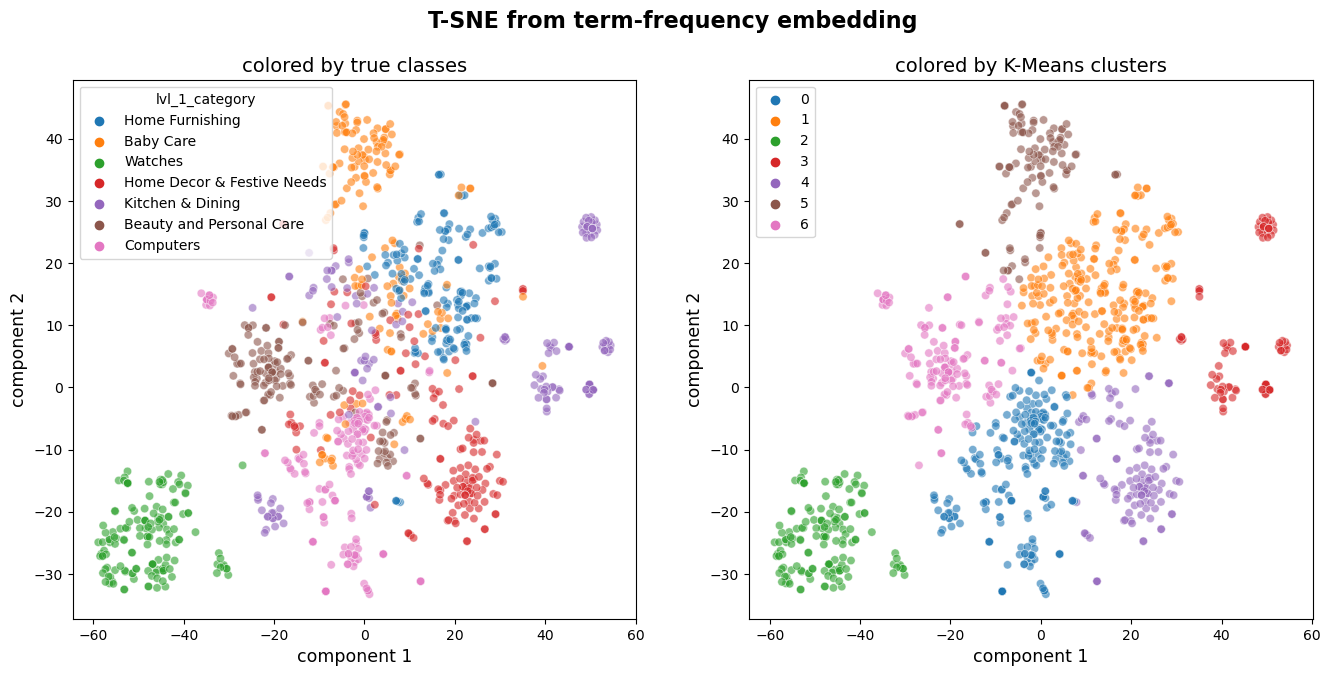

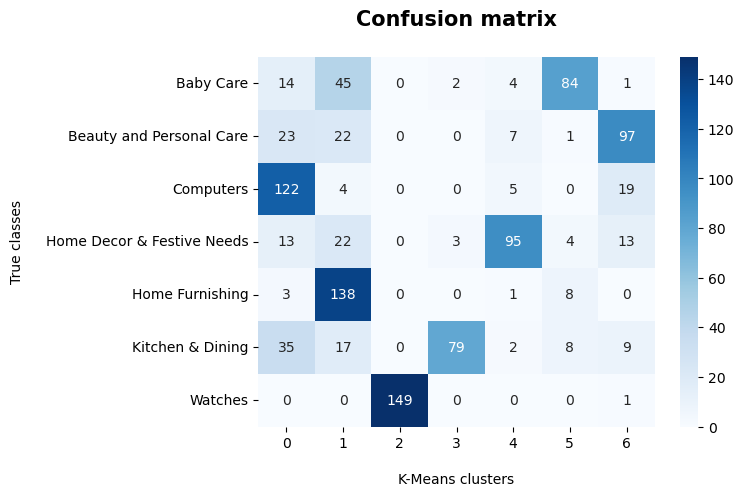

In [11]:
tf_pipeline = Pipeline([
    ('preprocessor', TextPreprocessor(remove_rare_tokens=True,
                                      min_token_len=2,
                                      only_eng=False,
                                      lemm_or_stemm='lemm')),
    ('vectorizer', CountVectorizer())
])

get_TSNE_ARI_confusion_matrix(tf_pipeline, X, 'term-frequency')

## On TF-IDF embedded data

Adjusted Rand Index =  0.51


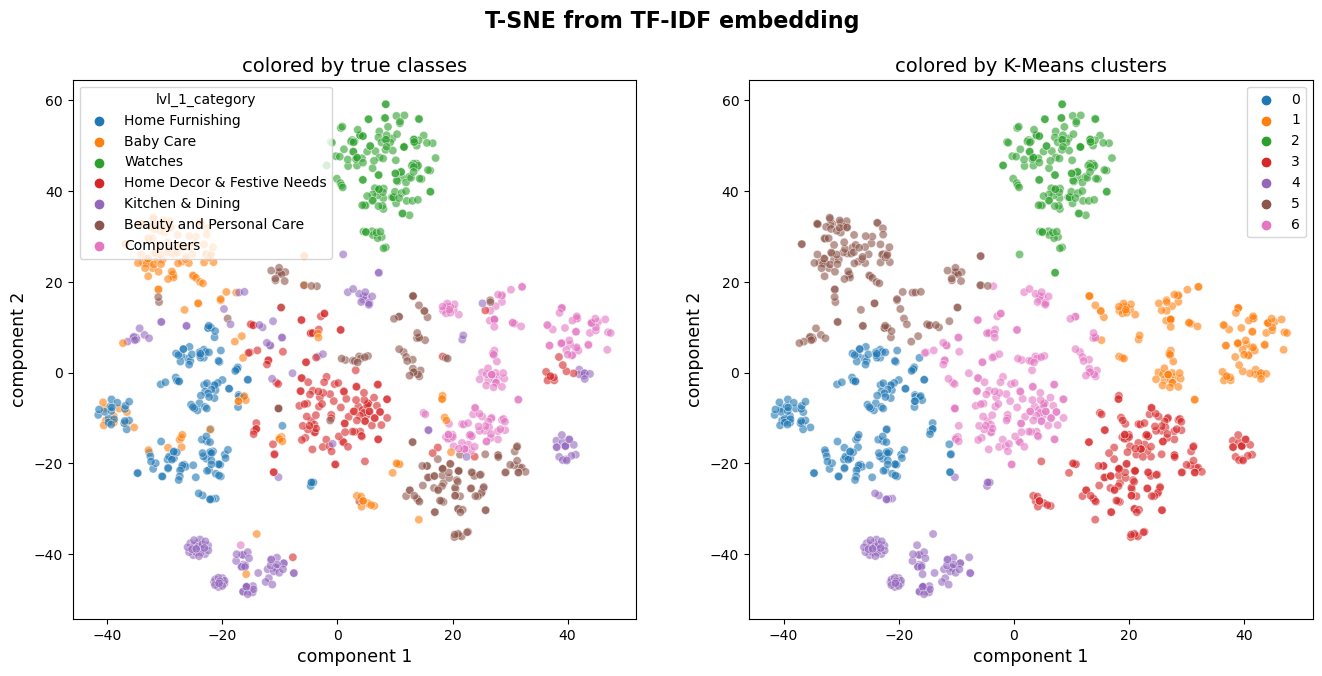

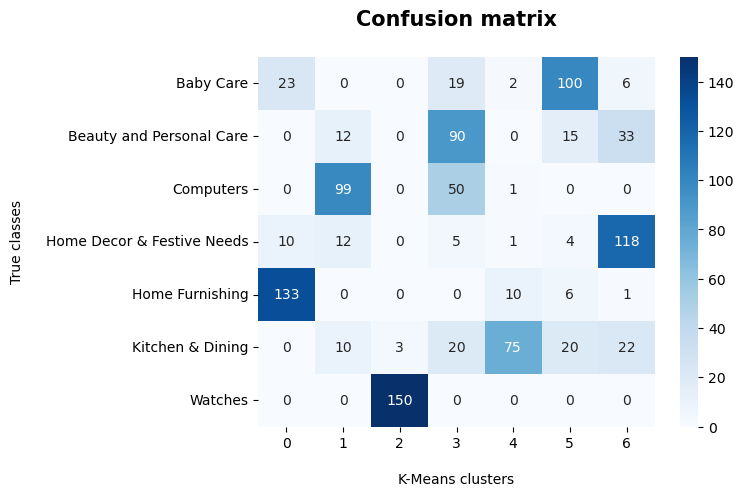

In [12]:
tfidf_pipeline = Pipeline([
    ('preprocessor', TextPreprocessor(remove_rare_tokens=False,
                                      min_token_len=2,
                                      only_eng=False,
                                      lemm_or_stemm='stemm')),
    ('vectorizer', TfidfVectorizer())
])

get_TSNE_ARI_confusion_matrix(tfidf_pipeline, X, 'TF-IDF')

## On D2V embedded data

Adjusted Rand Index =  0.21


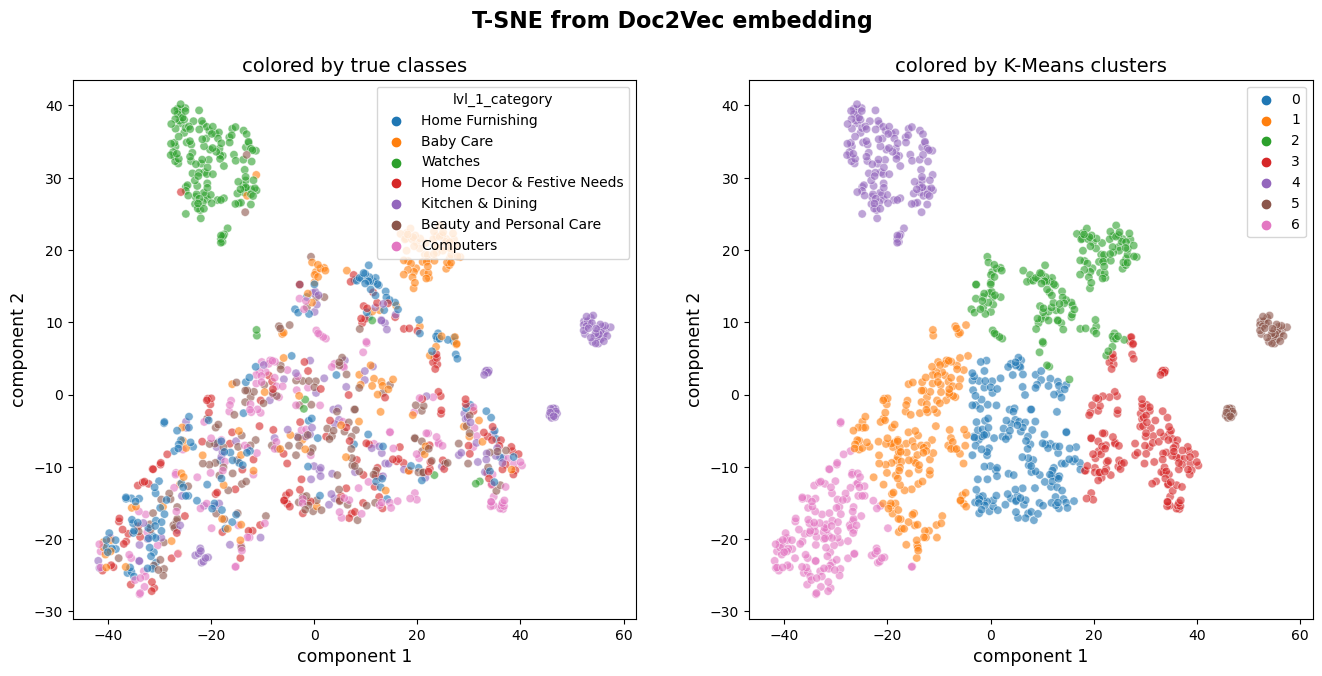

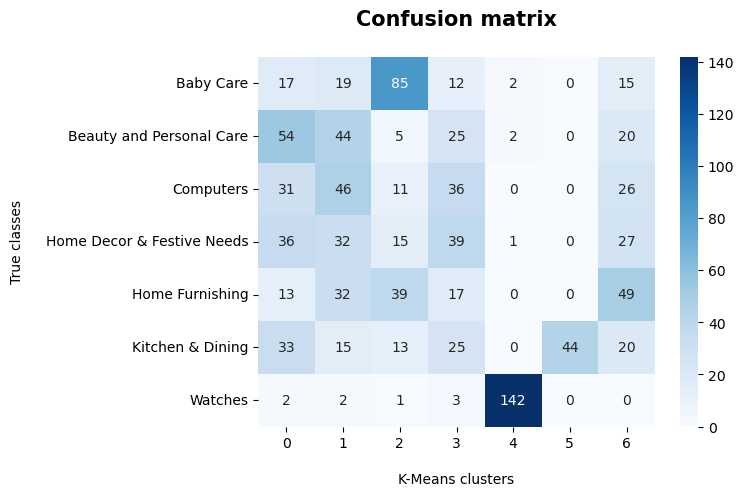

In [13]:
D2V_pipeline = Pipeline([
    ('preprocessor', TextPreprocessor(remove_rare_tokens=True,
                                      min_token_len=2,
                                      only_eng=False,
                                      lemm_or_stemm='lemm',
                                      rejoin=False)),
    ('vectorizer', D2VTransformer())
])

get_TSNE_ARI_confusion_matrix(D2V_pipeline, X, 'Doc2Vec')

## On BERT embedded data

Adjusted Rand Index =  0.26


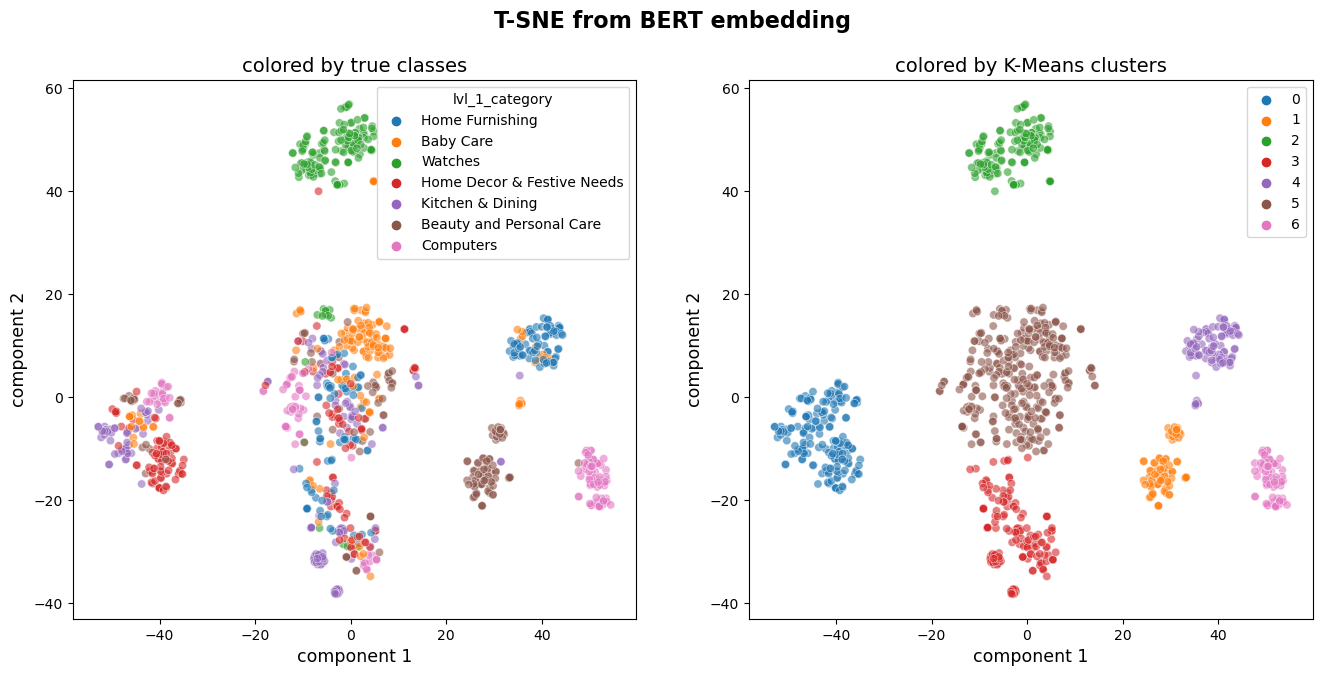

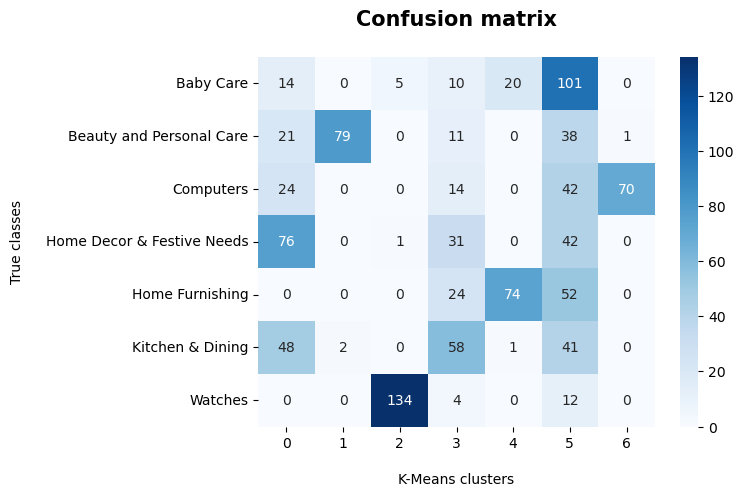

In [14]:
get_TSNE_ARI_confusion_matrix(bert_transformer, X, 'BERT')

## On USE embedded data

Adjusted Rand Index =  0.44


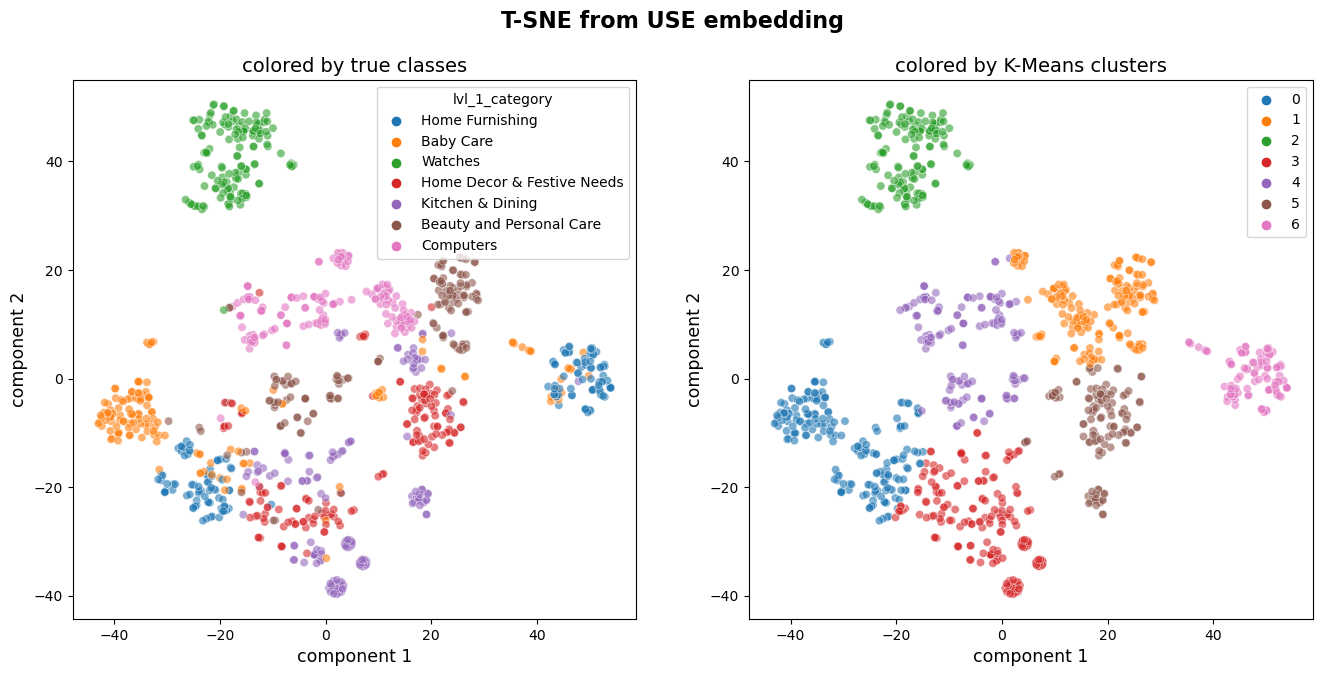

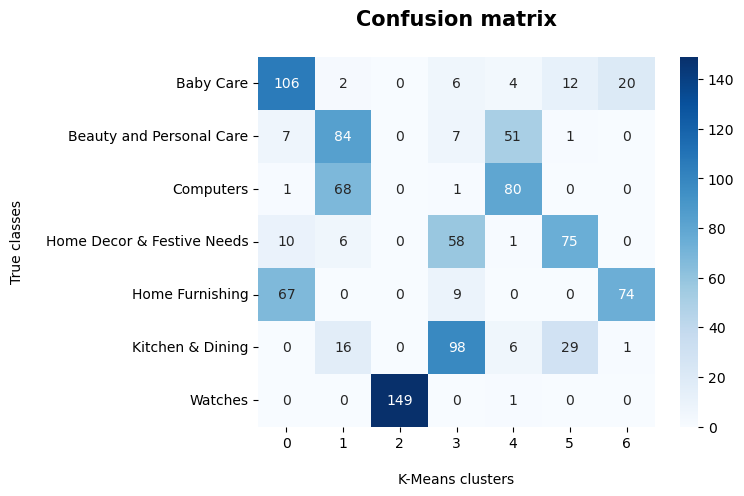

In [18]:
get_TSNE_ARI_confusion_matrix(USE_wrapper, X, 'USE')

# Supervised classification (supplement)

## Preprocessing grid search

In [ ]:
# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

# Define the parameters for GridSearchCV
param_grid = [
    {
        'preprocessor': [TextPreprocessor()],
        'preprocessor__remove_rare_tokens': [True, False],
        'preprocessor__min_token_len': [1, 2],
        'preprocessor__only_eng': [True, False],
        'preprocessor__lemm_or_stemm': [None, "lemm", "stemm"],
        'vectorizer': [CountVectorizer(), TfidfVectorizer()],
        'classifier': [LogisticRegression(max_iter=1000), SGDClassifier()]       
    },
    {
        'preprocessor': [TextPreprocessor(rejoin=False)],
        'preprocessor__remove_rare_tokens': [True, False],
        'preprocessor__min_token_len': [1, 2],
        'preprocessor__only_eng': [True, False],
        'preprocessor__lemm_or_stemm': [None, "lemm", "stemm"],
        'vectorizer': [D2VTransformer()],
        'classifier': [LogisticRegression(max_iter=1000), SGDClassifier()],       
    },
    {
        'preprocessor': ['passthrough'],
        'vectorizer': [bert_transformer],
        'classifier': [LogisticRegression(max_iter=1000), SGDClassifier()]
    },
    {
        'preprocessor': ['passthrough'],
        'vectorizer': [USE_wrapper],
        'classifier': [LogisticRegression(max_iter=1000), SGDClassifier()]
    }
]

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring='adjusted_rand_score', cv=5, n_jobs=-1)
grid_search.fit(X, y)

In [ ]:
# Display results
results = pd.DataFrame(grid_search.cv_results_)
cols = [
    'rank_test_score', 
    'params', 
    'mean_test_score', 
    'std_test_score',
    'param_classifier',
    'param_vectorizer',  
    'param_preprocessor',
    'param_preprocessor__remove_rare_tokens',
    'param_preprocessor__min_token_len',
    'param_preprocessor__only_eng',
    'param_preprocessor__lemm_or_stemm',
    'mean_fit_time',
    'std_fit_time',
    'mean_score_time',
    'std_score_time'
]
results = results.loc[:, cols]
results = results.sort_values('rank_test_score')
with option_context('display.max_colwidth', None, 'display.max_rows', None): display(results)

## Estimator grid search

In [ ]:
# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', TextPreprocessor()),
    ('vectorizer', CountVectorizer()),
    ('classifier', LogisticRegression())
])

# Define the parameters for GridSearchCV >>>>>>>>>>>>>  to be completed : add parameters to test
param_grid = [
    {
        'preprocessor': ['passthrough'],
        'vectorizer': [bert_transformer],
        'classifier': [LogisticRegression(max_iter=1000)],
    },
    {
        'preprocessor': [TextPreprocessor(remove_rare_tokens=False,
                                          min_token_len=2,
                                          only_eng=False,
                                          lemm_or_stemm='stemm')],
        'vectorizer': [TfidfVectorizer()],
        'classifier': [SGDClassifier()]
    }
]

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring='adjusted_rand_score', cv=5, n_jobs=-1)
grid_search.fit(X, y)

In [ ]:
# Display results
results = pd.DataFrame(grid_search.cv_results_)
cols = [
    'rank_test_score', 
    'params', 
    'mean_test_score', 
    'std_test_score',
    'param_classifier',
    'param_vectorizer',  
    'param_preprocessor',
    'mean_fit_time',
    'std_fit_time',
    'mean_score_time',
    'std_score_time'
]
results = results.loc[:, cols]
results = results.sort_values('rank_test_score')
with option_context('display.max_colwidth', None, 'display.max_rows', None): display(results)